# t-SNE analysis of velocity components

## 1. Libraries import

In [10]:
source('lib_import.R')
source('setup.R')
library(Rtsne)
library(cowplot)
library(timetk)
library(plyr)
library(latex2exp)

[1] "setting up ggplot theme and colours"


## 2. Velocity data import

In [4]:
source('velocity_data_import.R')

[1] "reading velocities"
[1] "* * * * * * * Part 1 * * * * * * * *"
[1] "cleaning velocity dataframe"
[1] "* * * * * * * Part 2 * * * * * * * *"
[1] "removing imroper values form v2"
[1] "creating month-year factor for df.v and df.v2"
[1] "Finished creating df.v and df.v2 data frames."
[1] "Creatng merged data frame: df.v.merged"


`summarise()` has grouped output by 'point'. You can override using the
`.groups` argument.


## 3. Data preparation

### 3.1. Determining trends of the velocity data

In [5]:
roll.period.main.trend = 30
roll.period.seasonal.trend = 8


pts <- levels(df.v.merged$point)
dpths <- levels(df.v.merged$depth)

df.v.trends <- NULL

for (pt in pts){
    tmp.df.v.pt <- df.v.merged[df.v.merged$point==pt,] 
    for (dpt in dpths){
        tmp.df <- tmp.df.v.pt[tmp.df.v.pt$depth==dpt,] 
        if (nrow(tmp.df)>0){
            tmp.df <- tmp.df %>%  mutate(
                         velocityN.trend=slidify_vec(.x = velocityN,
                                                     .period = roll.period.main.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center"),
                         velocityE.trend=slidify_vec(.x = velocityE,
                                                     .period = roll.period.main.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center"))
  
            tmp.df <- tmp.df %>%  mutate(
                         velocityN.seasonal=slidify_vec(.x = velocityN,
                                                     .period = roll.period.seasonal.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center") - velocityN.trend,
                         velocityE.seasonal=slidify_vec(.x = velocityE,
                                                     .period = roll.period.seasonal.trend,
                                                     .f=mean,na.rm   = TRUE,
                                                     .align  = "center") - velocityE.trend)            

            tmp.df <- tmp.df %>%  mutate(
                         velocityN.random= velocityN - velocityN.trend - velocityN.seasonal,
                         velocityE.random= velocityE - velocityE.trend - velocityE.seasonal)             
            
            if (is.null(df.v.trends)){
                df.v.trends <- tmp.df
            } else {
                df.v.trends <- rbind(df.v.trends,tmp.df)
            }
        }
    }
}
head(df.v.trends)

,date_time,speed,heading,velocityN,velocityE,depth,point,kelp,m.yr.factor,w.yr.factor,velocityN.trend,velocityE.trend,velocityN.seasonal,velocityE.seasonal,velocityN.random,velocityE.random
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-08-13 00:00:00,1.89,180.44,-1.89,-0.01,7,GF,FALSE,Aug21,W33-21,NA,NA,NA,NA,NA,NA
2,2021-08-13 00:05:00,1.64,177.22,-1.63,0.08,7,GF,FALSE,Aug21,W33-21,NA,NA,NA,NA,NA,NA
3,2021-08-13 00:10:00,1.85,177.76,-1.85,0.07,7,GF,FALSE,Aug21,W33-21,NA,NA,NA,NA,NA,NA
4,2021-08-13 00:15:00,1.88,179.00,-1.88,0.03,7,GF,FALSE,Aug21,W33-21,NA,NA,NA,NA,NA,NA
5,2021-08-13 00:20:00,2.12,200.43,-1.99,-0.74,7,GF,FALSE,Aug21,W33-21,NA,NA,NA,NA,NA,NA
6,2021-08-13 00:25:00,2.50,210.17,-2.16,-1.26,7,GF,FALSE,Aug21,W33-21,NA,NA,NA,NA,NA,NA


### 3.2. Creating dataframe with hourly trend values

In [6]:
tmp.df <- df.v.trends %>% 
group_by(date_time=floor_date(date_time,unit="hour"),point,depth) %>% 
summarize(mean.velN.t=mean(velocityN.trend,na.rm = TRUE),
          mean.velE.t=mean(velocityE.trend,na.rm = TRUE),
          mean.velN.s=mean(velocityN.seasonal,na.rm = TRUE),
          mean.velE.s=mean(velocityE.seasonal,na.rm = TRUE),
          m.yr.factor=first(m.yr.factor),
          kelp=first(kelp)) %>% na.omit()

head(tmp.df)

`summarise()` has grouped output by 'date_time', 'point'. You can override
using the `.groups` argument.


date_time,point,depth,mean.velN.t,mean.velE.t,mean.velN.s,mean.velE.s,m.yr.factor,kelp
<dttm>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>
2021-07-31 13:00:00,S2,7,-1.617033333,-0.2897667,0.02878333,-0.01773333,Jul21,TRUE
2021-07-31 13:00:00,S2,10,-1.175366667,0.9137000,0.15286667,-0.09720000,Jul21,FALSE
2021-07-31 13:00:00,S2,15,0.069800000,1.8514667,-0.02005000,-0.07009167,Jul21,FALSE
2021-07-31 13:00:00,S2,25,3.934700000,-0.5998333,0.16217500,-0.05291667,Jul21,FALSE
2021-07-31 14:00:00,S1,7,-0.002571429,0.6316190,0.97042857,-1.46501190,Jul21,TRUE
2021-07-31 14:00:00,S1,10,0.336166667,0.3238333,0.25070833,-0.47612500,Jul21,TRUE


### 3.3. Performing t-SNE analysis
*Remark*:  Each run the outcome can be a bit different due to random parameters used in t-SNE

In [34]:
tsne.res <- Rtsne(as.matrix(tmp.df[c("mean.velN.t","mean.velE.t","mean.velN.s","mean.velE.s")]),theta=0.25, perplexity=50, max_iter = 2500,num_threads = 4)
tsne.res.df <- data.frame(x1=tsne.res$Y[,1],
                          x2=tsne.res$Y[,2],
                          site=tmp.df$point,
                          depth=tmp.df$depth,
                          m.yr.factor=tmp.df$m.yr.factor,
                          kelp=tmp.df$kelp)

head(tsne.res.df)

,x1,x2,site,depth,m.yr.factor,kelp
,<dbl>,<dbl>,<fct>,<fct>,<ord>,<fct>
1,-31.179426,22.973412,S2,7,Jul21,TRUE
2,38.480036,-33.897561,S2,10,Jul21,FALSE
3,6.839821,8.036976,S2,15,Jul21,FALSE
4,18.688903,17.157229,S2,25,Jul21,FALSE
5,20.878295,-10.384661,S1,7,Jul21,TRUE
6,18.465625,-15.494133,S1,10,Jul21,TRUE


### 3.5. t-SNE results visualization
Adding a depth column to t-SNE dataframe

In [35]:
pd.lev <- flatten(map(as.character(levels(tsne.res.df$site)),function(e){return (paste(e,as.character(levels(tsne.res.df$depth)),sep="-"))}))
tsne.res.df$point.depth <- factor(paste(as.character(tsne.res.df$site),as.character(tsne.res.df$depth),sep="-"),
                                  levels=pd.lev, ordered=TRUE)

levels(tsne.res.df$point.depth)

[1] "GF-7"  "GF-10" "GF-15" "GF-25" "H-7"   "H-10"  "H-15"  "H-25"  "S1-7" 
[10] "S1-10" "S1-15" "S1-25" "S2-7"  "S2-10" "S2-15" "S2-25"

Settinng up theme

In [36]:
tsne.theme <- theme(
      axis.title = element_text(size=28),
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      legend.position = "top",
      legend.title = element_text(size=28),
      legend.text = element_text( size=24),
      legend.key.height = unit(0.75, 'cm'),
      legend.key.width= unit(1.25, 'cm')) 

lab.x1 <- TeX("$t-SNE \\; x_1$")
lab.x2 <- TeX("$t-SNE \\; x_2$")

In [37]:
options(repr.plot.width=20, repr.plot.height=20)
tsne.plotA <- ggplot(tsne.res.df,aes(x=x1,y=x2,color=site)) + geom_point(shape=1,size=1) + 
scale_color_manual(values=pts.color) + 
ylab(lab.x2) +
tsne.theme + 
guides(colour = guide_legend(override.aes = list(size=3,stroke=1))) + theme(axis.title.x = element_blank()) 

#tsne.plotA 

In [38]:
options(repr.plot.width=20, repr.plot.height=20)
tsne.plotB <- ggplot(tsne.res.df,aes(x=x1,y=x2,color=kelp)) + geom_point(shape=1,size=1) + 
scale_color_manual(name="kelp presence",values=c('FALSE'='#00BFC4','TRUE'='#F8766D'),labels=c('FALSE'="no",'TRUE'="yes")) + 
tsne.theme+ 
guides(colour = guide_legend(override.aes = list(size=3,stroke=1))) +  theme(axis.title = element_blank())

#tsne.plotB

In [39]:
options(repr.plot.width=20, repr.plot.height=20)
tsne.plotC <- ggplot(tsne.res.df,aes(x=x1,y=x2,color=depth)) + geom_point(shape=1,size=1) +
scale_color_brewer(palette = "Greens",labels = c("7 [m]","10 [m]", "15 [m]", "25 [m]")) + 
xlab(lab.x1) + ylab(lab.x2) +
tsne.theme+ theme(legend.margin = margin(t = 0.5, unit='cm'))+
guides(colour = guide_legend(override.aes = list(size=3,stroke=1)))

#tsne.plotC

In [40]:
date.lab.fun <- function(x){
   return(levels(tsne.res.df$m.yr.factor)[x])
}

options(repr.plot.width=20, repr.plot.height=20)
tsne.plotD <- ggplot(tsne.res.df,aes(x=x1,y=x2,color=as.integer(m.yr.factor))) + geom_point(size=0.5) +
scale_colour_gradient(name="time",low="grey90",high="grey40",labels=date.lab.fun) +
xlab(lab.x1)+
tsne.theme +  theme(
      axis.title.y = element_blank(),
      legend.text = element_text( size=20),
      legend.key.height = unit(0.45, 'cm'),
      legend.key.width= unit(3, 'cm'),
      legend.margin = margin(t = 0, b=0, unit='cm')) 

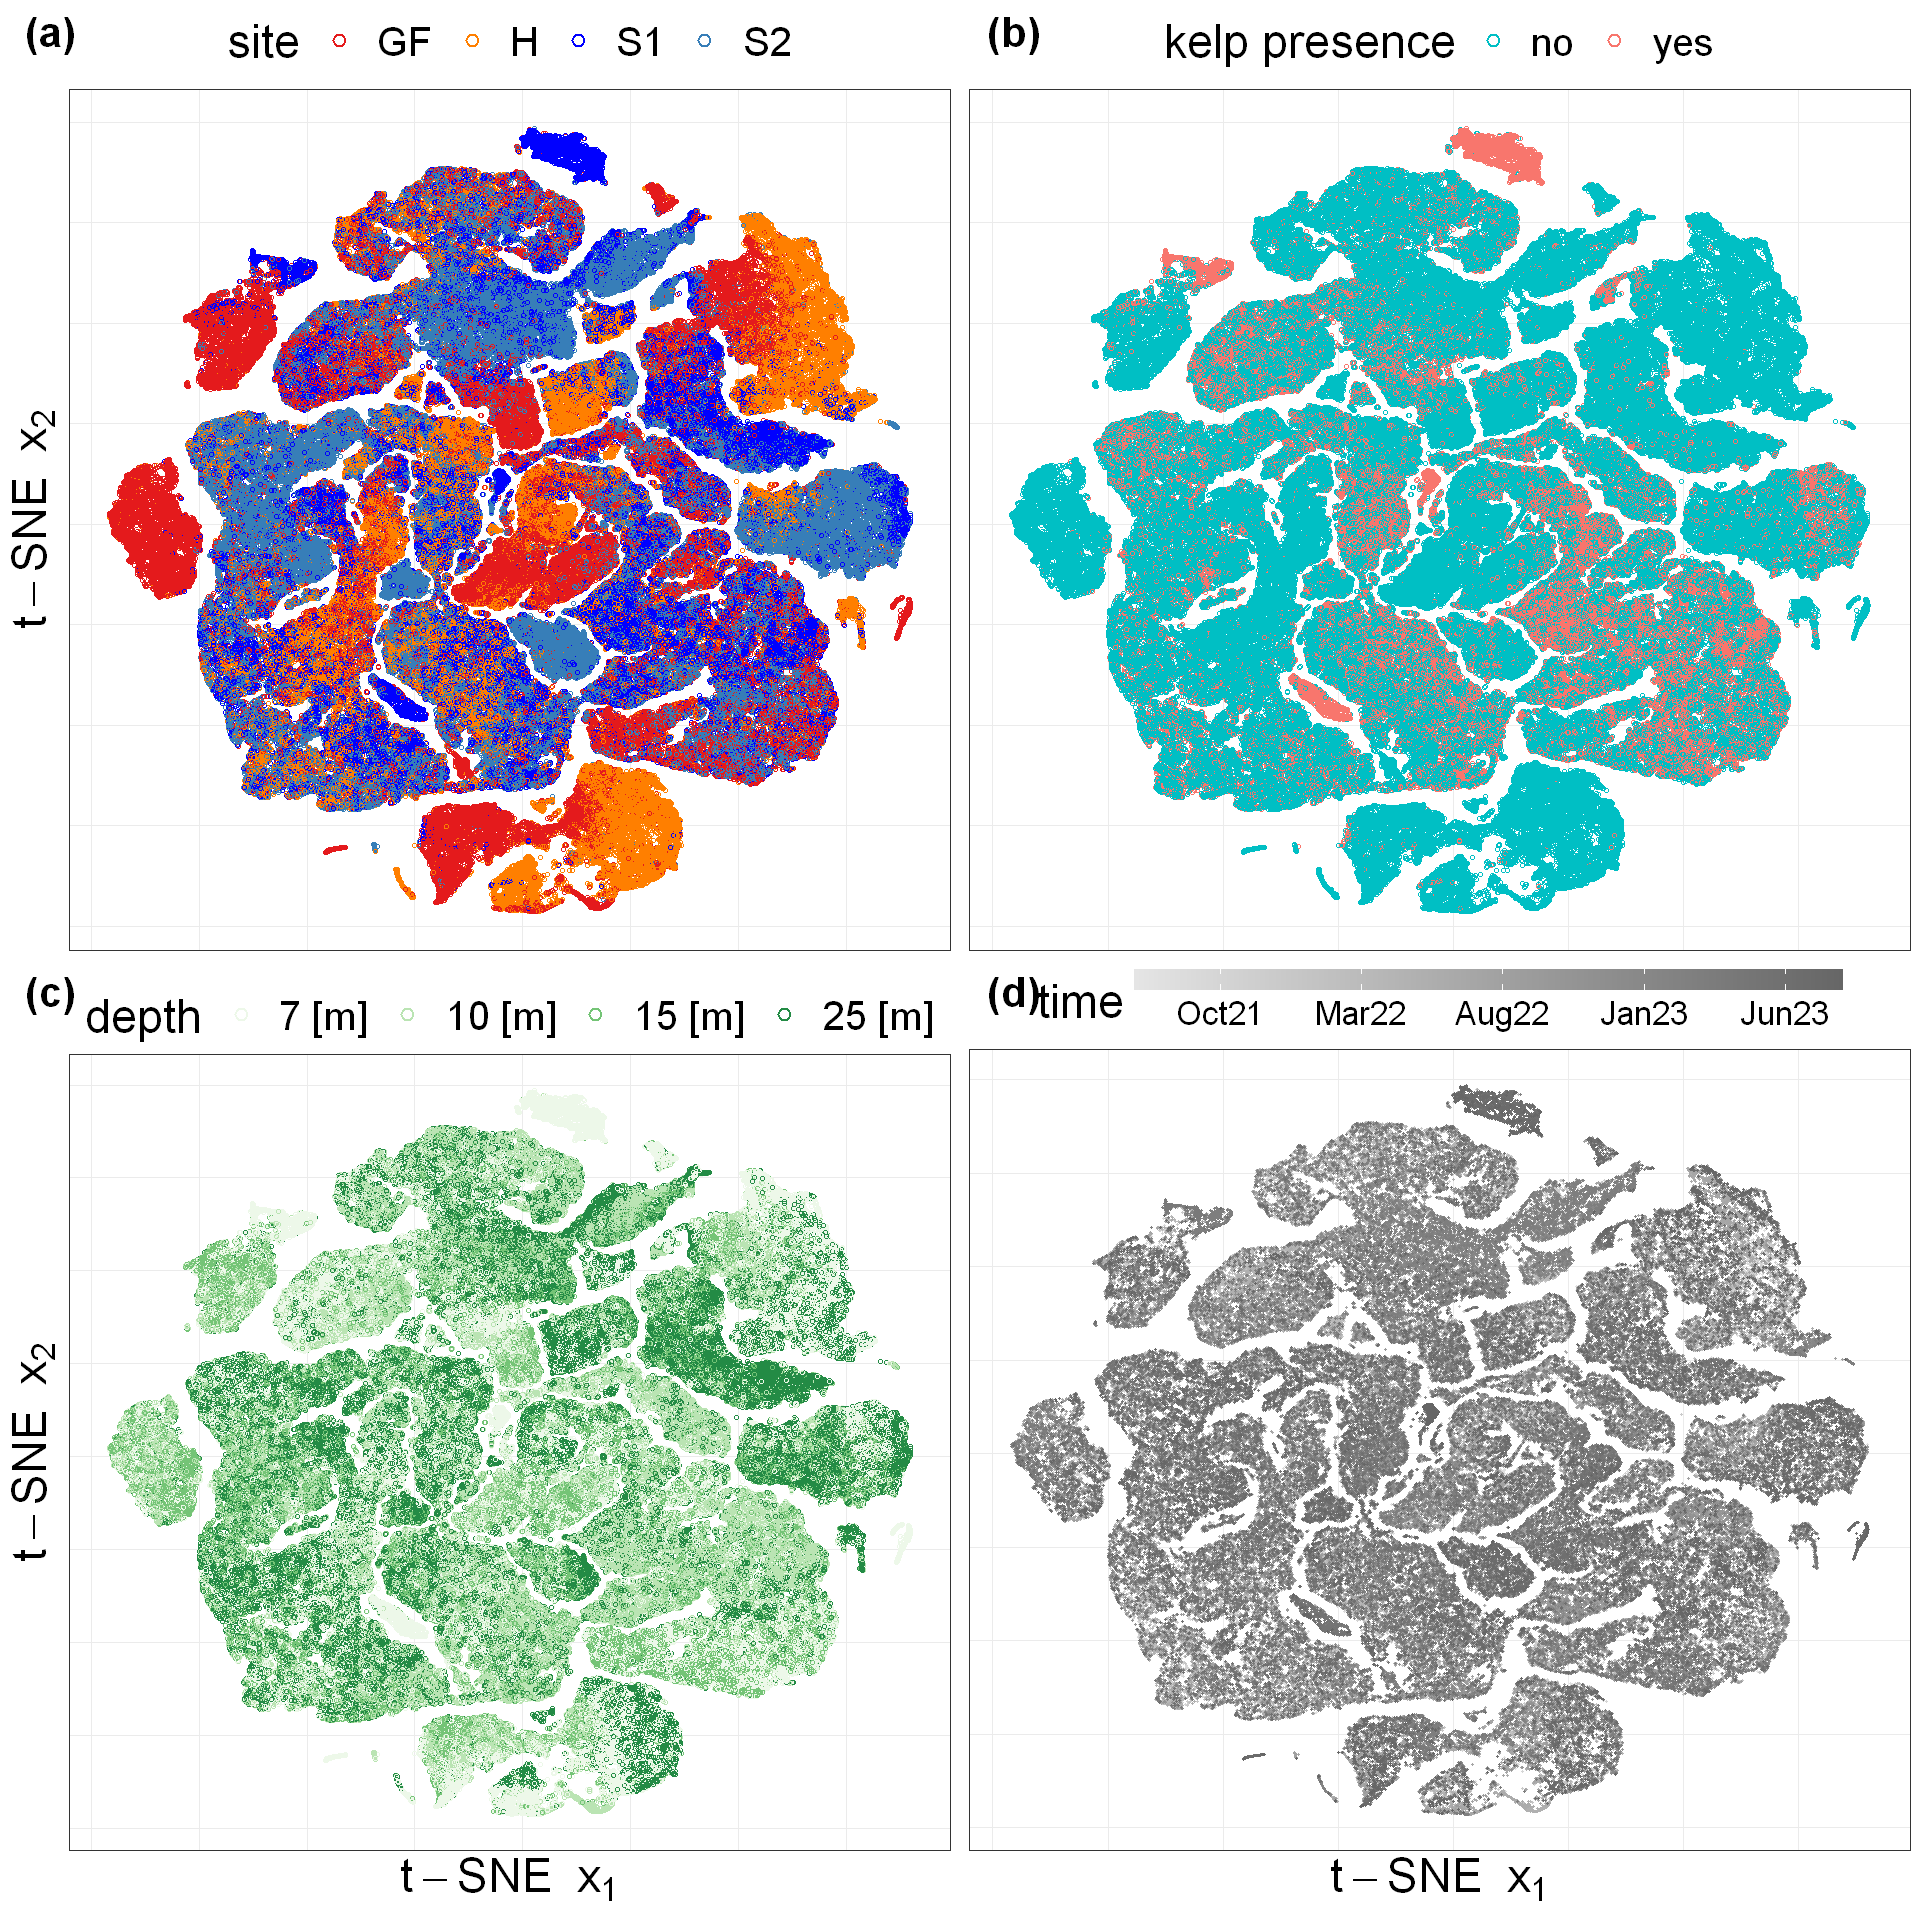

In [41]:
options(repr.plot.width=16, repr.plot.height=16)
plot_grid(tsne.plotA, tsne.plotB, 
          tsne.plotC, tsne.plotD, 
          labels = c('(a)', '(b)','(c)','(d)'), label_size = 25, nrow=2)